# Tvorba strukturovaných sítí

V této lekci si ukážeme několik postupů pro tvorbu strukturovaných sítí. Pro jednoduchost se omezíme na dvourozměrný případ. Zde uvedené algoritmy lze však rozšířit i pro sestavení sítí ve 3D. Dále budeme uvažovat pouze sítě tvořené jedním blokem.

Vzhledem k tomu, že sítě jsou strukturované, budeme je v počítači reprezentovat jako dvourozměrná pole obsahující souřadnice uzlových bodů sítě, tj. jako pole
```
  x[n,m] :: Float64
  y[n,m] :: Float64
```
případně jako dvourozměrné pole polohových vektorů uzlových bodů sítě
```
  r[2,n,m] :: Float64
```
($n$ a $m$ jsou počtu bodů sítě v jednotlivých směrech).

## Pomocné funkce pro zobrazení sítí

In [1]:
using Plots;
pyplot();

In [2]:
using LinearAlgebra;
using SparseArrays;

In [3]:
# Vykresleni hranice oblasti
function plot_boundary(x,y)
    plt = plot(aspect_ratio=:equal, legend=:none)
    plot!(plt, x[1,:], y[1,:], c="red", m=:x)
    plot!(plt, x[end,:], y[end,:], c="red", m=:x)
    plot!(plt, x[:,1], y[:,1], c="red", m=:x)
    plot!(plt, x[:,end], y[:,end], c="red", m=:x)
    return plt;
end;
    
# Vykresleni site zadane dvojici poli se souradnicemi x a y
function plot_mesh(x,y)
    @assert size(x)==size(y) 
    n,m = size(x)
    plt=plot_boundary(x,y);
    for i=2:n-1
        plot!(plt, x[i,:], y[i,:], c="blue")
    end
    for j=2:m-1
        plot!(plt, x[:,j], y[:,j], c="blue")
    end
    return plt;
end;

# Vykreselni site zadane jako pole polohovych vektoru
function plot_mesh(r)
    @assert ndims(r)==3 && size(r,1)==2 
    _, n, m = size(r)
    
    plt = plot(aspect_ratio=:equal, legend=:none)
    plot!(plt, r[1,:,1], r[2,:,1], c="red", m=:x)
    for j=2:m
        plot!(plt, r[1,:,j], r[2,:,j], c="blue")
    end
    for i=1:n
        plot!(plt, r[1,i,:], r[2,i,:], c="blue")
    end
    return plt;
end;

## Definice oblastí pro testování algoritmů

### Kanál s půlkruhovým zúžením

In [4]:
function channel(n,m)
    x = zeros(n,m);  y = zeros(n,m)
    
    x[1,:] .= 0.0; y[1,:] = range(0,1,length=m)
    x[n,:] .= 3.0; y[n,:] = range(0,1,length=m)
    x[:,m] = range(0,3,length=n); y[:,m] .= 1.0
    
    length = 2 + π/2
    ds = length / (n-1)
    for i in 1:n
        s = (i-1) * ds
        if s < 1   
            x[i,1] = s; y[i,1] = 0;
        elseif s < 1 + π/2
            ϕ = 2*(s - 1)
            x[i,1] = 1.5 - 0.5*cos(ϕ)
            y[i,1] = 0.5*sin(ϕ)
        else
            x[i,1] = s + 1 - π/2; y[i,1] = 0
        end
    end
    return x,y
end

channel (generic function with 1 method)

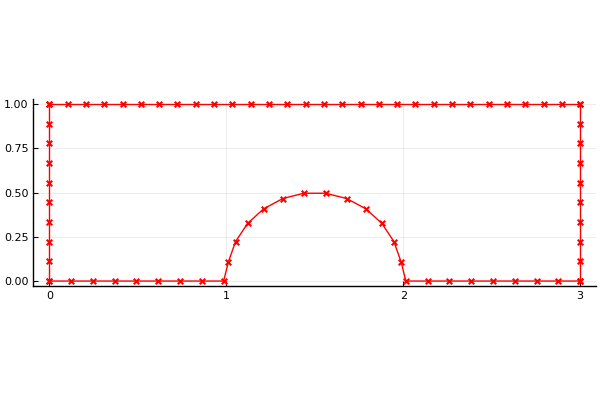

In [5]:
chx,chy = channel(30,10);
plot_boundary(chx,chy)

### Kanál s půlkruhovým zúžením a zjemněním u spodní hranice

In [6]:
function channel_ns(n,m)
    x = zeros(n,m);  y = zeros(n,m)
    
    x[1,:] .= 0.0; y[1,:] = range(0,1,length=m).^1.5
    x[n,:] .= 3.0; y[n,:] = range(0,1,length=m).^1.5
    x[:,m] = range(0,3,length=n); y[:,m] .= 1.0
    
    length = 2 + π/2
    ds = length / (n-1)
    for i in 1:n
        s = (i-1) * ds
        if s < 1   
            x[i,1] = s; y[i,1] = 0;
        elseif s < 1 + π/2
            ϕ = 2*(s - 1)
            x[i,1] = 1.5 - 0.5*cos(ϕ)
            y[i,1] = 0.5*sin(ϕ)
        else
            x[i,1] = s + 1 - π/2; y[i,1] = 0
        end
    end
    return x,y
end

channel_ns (generic function with 1 method)

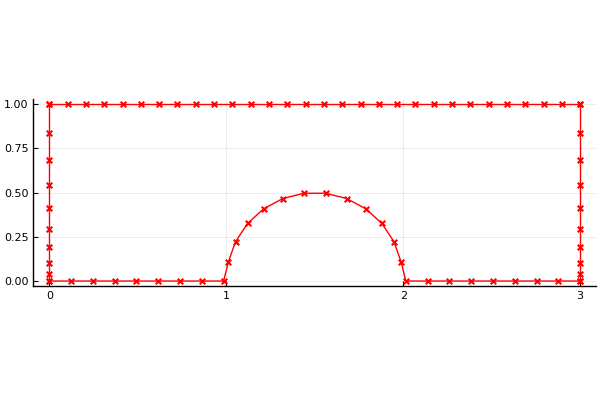

In [7]:
nsx,nsy = channel_ns(30,10);
plot_boundary(nsx,nsy)

In [8]:
function curved_rectangle(n,m)
    x = zeros(n,m);  y = zeros(n,m)
    
    x[:,1] = range(0,1,length=n)
    y[:,1] = (x[:,1] .- 0.5).^2/2 .- 0.125

    x[:,end] = range(0,1,length=n)
    y[:,end] = 1.125 .- (x[:,1] .- 0.5).^2/2

    y[1,:] = range(0,1,length=m)
    x[1,:] = 0.125 .- (y[1,:] .- 0.5).^2/2

    y[end,:] = range(0,1,length=m)
    x[end,:] = 1.125 .- (y[end,:] .- 0.5).^2/2

    return x,y
end

curved_rectangle (generic function with 1 method)

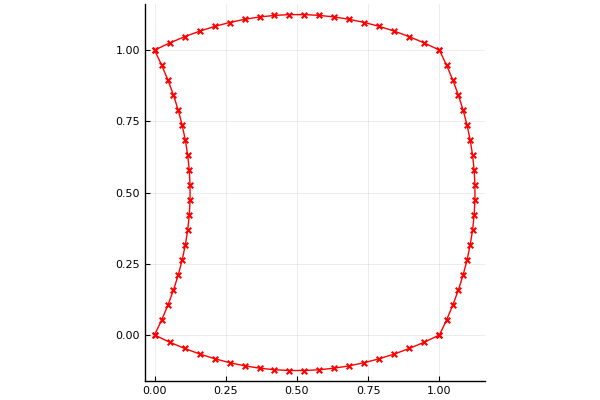

In [9]:
crx,cry = curved_rectangle(20,20);
plot_boundary(crx,cry)

## Algebraická síť 

### Jednosměrná interpolace

Spodní a horní hranice sítě je dána pomocí dvojice parametrických křivek $\vec{r}_{d}(\xi)$ a $\vec{h}_{01}(\xi)$ s $\xi \in [0,1]$. Dále je na intervalu $[0,1]$ dána rostoucí funkce $h$ taková, že $h(0)=0$ a $h(1)=1$. Potom jsou vrcholy sítě vypočteny jako

\begin{equation}
  \vec{r}_{ij} = (1-h(\eta_j))\vec{r}_d(\xi_i) + h(\eta_j)\vec{r}_h(\xi_i)
\end{equation}
kde $\xi_i = (i-1)/(n-1)$ a $\eta_j = (j-1)/(m-1)$.

Pozn. nejčasteji se volí $h(\eta)=\eta$.

In [10]:
function straight_j!(x,y, h=η->η)
    n,m = size(x)
    for j = 2:m-1
        η = (j-1) / (m-1)
        x[2:n-1,j] = (1-h(η)) * x[2:n-1,1] + h(η) * x[2:n-1,end]
        y[2:n-1,j] = (1-h(η)) * y[2:n-1,1] + h(η) * y[2:n-1,end]
    end
end

straight_j! (generic function with 2 methods)

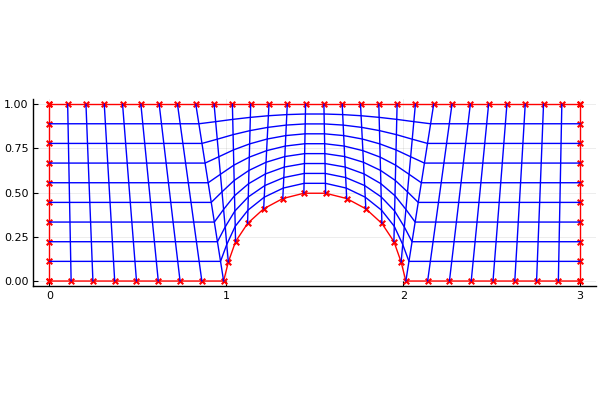

In [11]:
straight_j!(chx,chy);
plot_mesh(chx,chy)

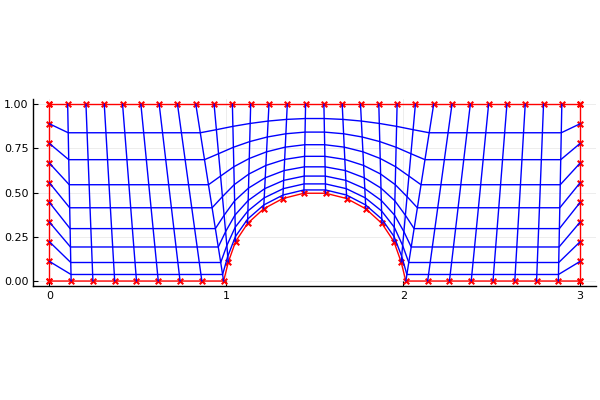

In [12]:
# Netrivialni volba h(eta)
chx2,chy2 = channel(30,10);
straight_j!(chx2,chy2,η->η^1.5);
plot_mesh(chx2,chy2)

Nevhodný případ (levá nebo pravá hranice není lineární)

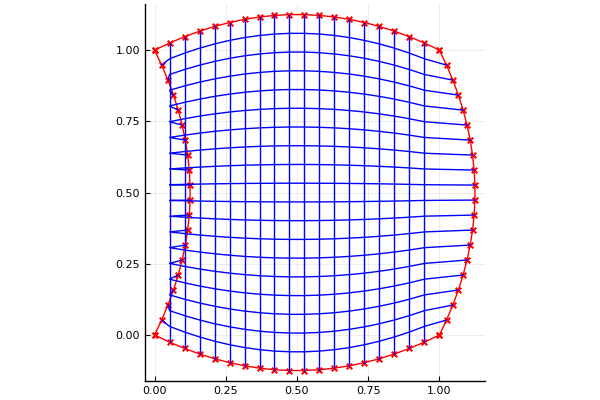

In [13]:
straight_j!(crx,cry);
plot_mesh(crx,cry)

### Transfinitní interpolace

Máme dány všechny čtyři hranice oblasti pomocí parametrických křivek $\vec{r}_d(\xi)$, $\vec{r}_h(\xi)$, $\vec{r}_l(\eta)$, $\vec{r}_p(\eta)$ s $\xi,\eta \in [0,1]$. 

Body sítě jsou potom
\begin{equation}
  \vec{r}_{ij} = \vec{u}_{ij} + \vec{v}_{ij} - \vec{uv}_{ij},
\end{equation}

kde
\begin{align}
    \vec{u}_{ij} &= (1-\eta_j) \vec{r}_d(\xi_i) + \eta_j \vec{r}_h(\xi_i), \\
    \vec{v}_{ij} &= (1-\xi_i) \vec{r}_l(\eta_j) + \xi_i \vec{r}_p(\eta_j), \\
    \vec{uv}_{ij} &= (1-\eta_j)(1-\xi_i) \vec{r}_d(0) + (1-\eta_j)\xi_i \vec{r}_d(1) + 
        \eta_j(1-\xi_i) \vec{r}_h(0) + \eta_j\xi_i \vec{r}_h(1). 
\end{align}

In [14]:
function linear_tfi!(x,y)
    n,m = size(x)
    
    for i=2:n-1
        ξ = (i-1) / (n-1)
        for j=2:m-1
            η = (j-1) / (m-1)
            
            ux = (1-ξ) * x[1,j] + ξ * x[n,j]
            uy = (1-ξ) * y[1,j] + ξ * y[n,j]

            vx = (1-η) * x[i,1] + η * x[i,m]
            vy = (1-η) * y[i,1] + η * y[i,m]
            
            uvx = (1-ξ)*(1-η) * x[1,1] + ξ*(1-η) * x[n,1] + (1-ξ)*η * x[1,m] + ξ*η * x[n,m]
            uvy = (1-ξ)*(1-η) * y[1,1] + ξ*(1-η) * y[n,1] + (1-ξ)*η * y[1,m] + ξ*η * y[n,m]
            
            x[i,j] = ux + vx - uvx
            y[i,j] = uy + vy - uvy            
        end
    end
end

linear_tfi! (generic function with 1 method)

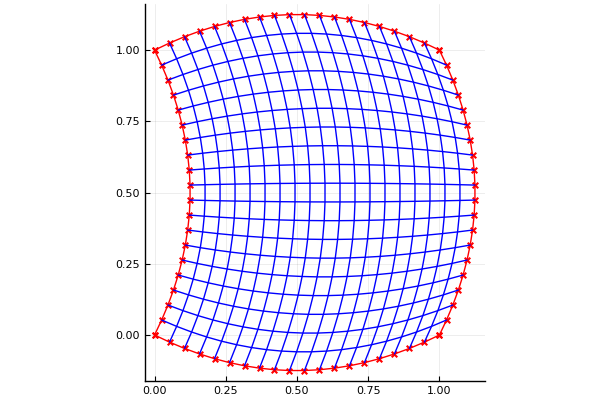

In [15]:
linear_tfi!(crx,cry);
plot_mesh(crx,cry)

Nevhodný případ: výrazně zakřivená hranice se zjemněním

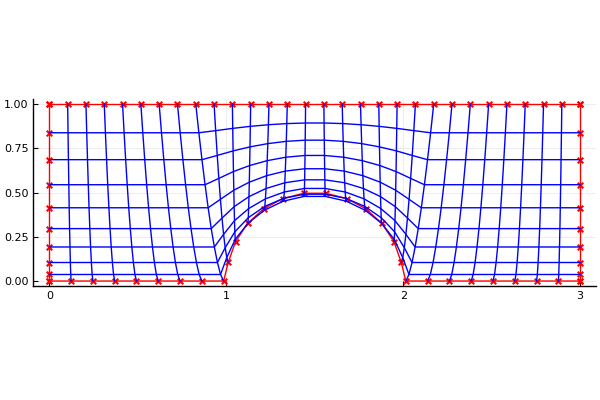

In [16]:
linear_tfi!(nsx,nsy);
plot_mesh(nsx,nsy)

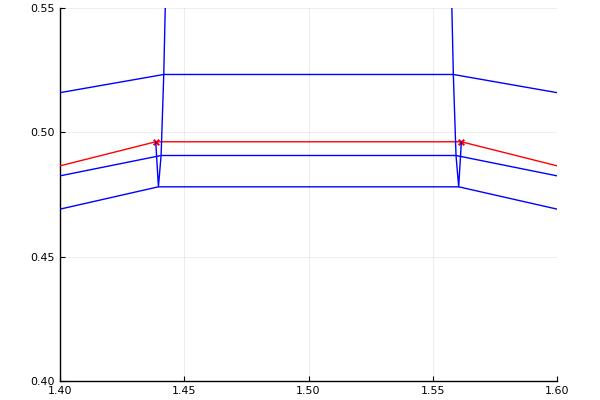

In [17]:
plt=plot_mesh(nsx,nsy)
plot!(plt, xlim=(1.4,1.6), ylim=(0.40,0.55))

#### "Dvojitá" transfinitní interpolace

* v prvním kroku přiřadíme bodům na hranici hodnoty $\xi$ a $\eta$ dle délky hraniční křivky
* tyto hodnoty interpolujeme do vnitřku oblasti pomocí obyčejné TFI interpolace
* souřadnice vrcholů pak určíme pomocí TFI s vypočtenými hodnotami $\xi$ a $\eta$

In [18]:
function double_tfi!(x,y; plot_ξη=false)
    n,m = size(x)

    # Vypocet xi a eta 
    ξ = zeros(n,m)
    η = zeros(n,m)
    
    # xi a eta na hranicich
    for i=2:n
        ξ[i,1] = ξ[i-1,1] + √((x[i,1]-x[i-1,1])^2 + (y[i,1]-y[i-1,1])^2)
        ξ[i,m] = ξ[i-1,m] + √((x[i,m]-x[i-1,m])^2 + (y[i,m]-y[i-1,m])^2)
    end
    ξ[:,1] = ξ[:,1] / ξ[n,1]
    ξ[:,m] = ξ[:,m] / ξ[n,m]
    η[:,m] .= 1.0

    for j=2:m
        η[1,j] = η[1,j-1] + √((x[1,j]-x[1,j-1])^2 + (y[1,j]-y[1,j-1])^2)
        η[n,j] = η[n,j-1] + √((x[n,j]-x[n,j-1])^2 + (y[n,j]-y[n,j-1])^2)
    end
    η[1,:] = η[1,:] / η[1,m]
    η[n,:] = η[n,:] / η[n,m]
    ξ[n,:] .= 1.0

    # Prepocet xi a eta dovnitr site
    linear_tfi!(ξ,η)
    
    
    plt = plot_mesh(ξ,η); 
    plot!(plt, xlabel="xi", ylabel="eta")
    
    # TFI s vypoctenymi hodnotami ξ a η
    for i=2:n-1
        for j=2:m-1
            
            ux = (1-ξ[i,j]) * x[1,j] + ξ[i,j] * x[n,j]
            uy = (1-ξ[i,j]) * y[1,j] + ξ[i,j] * y[n,j]

            vx = (1-η[i,j]) * x[i,1] + η[i,j] * x[i,m]
            vy = (1-η[i,j]) * y[i,1] + η[i,j] * y[i,m]
            
            uvx = (1-ξ[i,j])*(1-η[i,j]) * x[1,1] + ξ[i,j]*(1-η[i,j]) * x[n,1] + (1-ξ[i,j])*η[i,j] * x[1,m] + ξ[i,j]*η[i,j] * x[n,m]
            uvy = (1-ξ[i,j])*(1-η[i,j]) * y[1,1] + ξ[i,j]*(1-η[i,j]) * y[n,1] + (1-ξ[i,j])*η[i,j] * y[1,m] + ξ[i,j]*η[i,j] * y[n,m]
            
            x[i,j] = ux + vx - uvx
            y[i,j] = uy + vy - uvy            
        end
    end
    return plt
end

double_tfi! (generic function with 1 method)

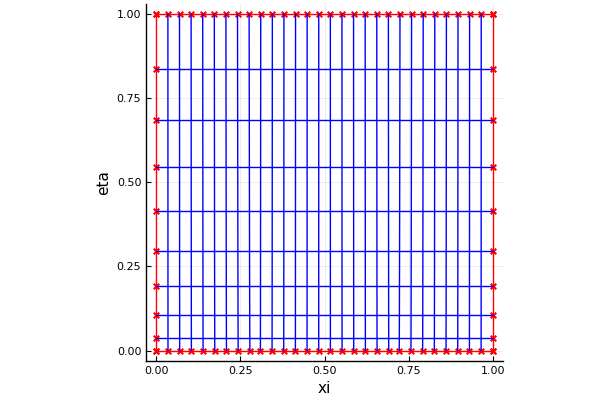

In [19]:
double_tfi!(nsx,nsy, plot_ξη=true)

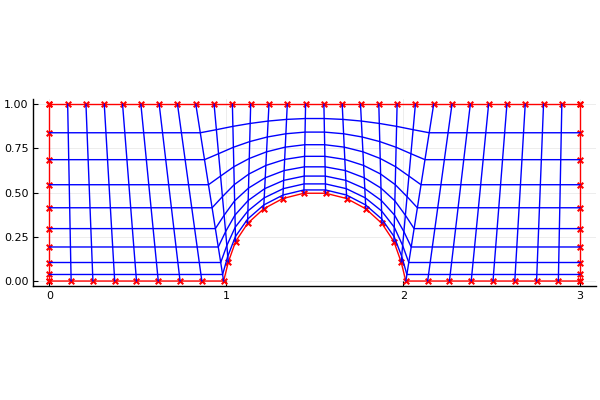

In [20]:
plot_mesh(nsx,nsy)

## Eliptický generátor

Síť získáme jako izočáry funkcí $\xi$ a $\eta$. Ty dostaneme řešením rovnic
\begin{align*}
    \Delta \xi(x,y) &= p(x,y), \\
    \Delta \eta(x,y) &= q(x,y), 
\end{align*}
s Dirichletovou okrajovou podmínkou (zadané souřadnice bodů na kraji oblasti).
Funkce $p$ a $q$ a jejich význam bude popsán níže.

* Transformace prvních derivací:
Mějme funkci $\phi(\xi(x,y), \eta(x,y))$ potom pro její parciální derivace platí 
\begin{align*}
    \phi_x &= \phi_\xi \xi_x + \phi_\eta \eta_x, \\
    \phi_y &= \phi_\xi \xi_y + \phi_\eta \eta_y.
\end{align*}

* Transformace druhých derivací:

\begin{align*}
    \phi_{xx} &= (\phi_{\xi\xi}\xi_x + \phi_{\xi\eta}\eta_x) \xi_x + \phi_\xi \xi_{xx} +
        (\phi_{\eta\xi}\xi_x + \phi_{\eta\eta}\eta_x) \eta_x + \phi_\eta \eta_{xx}, 
        \\
    \phi_{yy} &= (\phi_{\xi\xi}\xi_y + \phi_{\xi\eta}\eta_y) \xi_y + \phi_\xi \xi_{yy} +
        (\phi_{\eta\xi}\xi_y + \phi_{\eta\eta}\eta_y) \eta_y + \phi_\eta \eta_{yy}, 
\end{align*}

neboli

\begin{align*}
    \phi_{xx} &= \xi_x^2 \phi_{\xi\xi} + 2 \xi_x\eta_x \phi_{\xi\eta} + \eta_x^2 \phi_{\eta\eta} +  
        \xi_{xx} \phi_\xi +  \eta_{xx} \phi_\eta, 
        \\
    \phi_{yy} &= \xi_y^2 \phi_{\xi\xi} + 2 \xi_y\eta_y \phi_{\xi\eta} + \eta_y^2 \phi_{\eta\eta} +  
        \xi_{yy} \phi_\xi +  \eta_{yy} \phi_\eta. 
\end{align*}

Laplaceův operátor v křivočarých souřadnicích

$$
    \Delta \phi =
    (\nabla \xi \cdot \nabla \xi) \phi_{\xi\xi} +
    2(\nabla\xi\cdot\nabla\eta) \phi_{\xi\eta} + 
    (\nabla \eta \cdot \nabla \eta) \phi_{\eta\eta} + \Delta \xi \phi_\xi + \Delta \eta \phi_\eta
$$

Protože platí
$$
\begin{bmatrix}
\xi_x & \xi_y \\ \eta_x & \eta_y
\end{bmatrix} 
= 
\begin{bmatrix}
x_\xi & x_\eta \\ y_\xi & y_\eta
\end{bmatrix}^{-1}
= 
\frac{1}{J}
\begin{bmatrix}
y_\eta & - x_\eta \\ - y_\eta & x_\xi
\end{bmatrix},
$$
kde $J=x_\xi y_\eta - x_\eta y_\xi$, lze Laplaceův operátor vyjádřit jako

$$
    \Delta \phi =
    \frac{1}{J^2}(x_\eta^2+y_\eta^2) \phi_{\xi\xi} -
    \frac{2}{J^2}(x_\xi x_\eta + y_\xi y_\eta)\phi_{\xi\eta} + 
    \frac{1}{J^2}(x_\xi^2+y_\xi^2) \phi_{\eta\eta} + \Delta \xi \phi_\xi + \Delta \eta \phi_\eta
$$

Zvolíme-li nejprve $\phi=x$ a pak $\phi=y$ a rovnici násobíme $J^2$, dostaneme 
\begin{align*}
    0 &=(x_\eta^2+y_\eta^2) x_{\xi\xi} -
    2(x_\xi x_\eta + y_\xi y_\eta)x_{\xi\eta} + 
    (x_\xi^2+y_\xi^2) x_{\eta\eta} + J^2\Delta \xi x_\xi + J^2\Delta \eta x_\eta, \\
    0 &=(x_\eta^2+y_\eta^2) y_{\xi\xi} -
    2(x_\xi x_\eta + y_\xi y_\eta)y_{\xi\eta} + 
    (x_\xi^2+y_\xi^2) y_{\eta\eta} + J^2\Delta \xi y_\xi + J^2\Delta \eta y_\eta.
\end{align*}

Jestliže $\xi$ a $\eta$ splňují rovnice $\Delta \xi = p$ a $\Delta \eta = q$, lze výše uvedenou soustavu přepsat jako
$$
g_{22}(\vec{x}_{\xi\xi} + P \vec{x}_{\xi}) - 2 g_{12} \vec{x}_{\xi\eta} + g_{11}(\vec{x}_{\eta\eta}+Q \vec{x}_{\eta}) = 0,
$$
kde
\begin{align*}
    g_{11} &=\vec{x}_{\xi} \cdot \vec{x}_{\xi}, \\ 
    g_{12} &=\vec{x}_{\xi} \cdot \vec{x}_{\eta}, \\ 
    g_{22} &=\vec{x}_{\eta} \cdot \vec{x}_{\eta}, \\ 
    P &= \frac{J^2}{g_{22}} p, \\
    Q &= \frac{J^2}{g_{11}} q.    
\end{align*}

In [21]:
function elliptic_mesh!(x, y; P=(i,j)->0.0, Q=(i,j)->0.0, ϵ=1.e-4, maxiter=10000)
    n, m = size(x)
    
    linear_tfi!(x,y)       # Vytvoreni pocatecni site 
    
    err = Inf
    iter = 0
    
    while err > ϵ^2 && iter < maxiter
        iter = iter + 1
        err = 0.0
        for i=2:n-1, j=2:m-1
            x_ξ = (x[i+1,j] - x[i-1,j]) / 2.0
            y_ξ = (y[i+1,j] - y[i-1,j]) / 2.0
            x_η = (x[i,j+1] - x[i,j-1]) / 2.0
            y_η = (y[i,j+1] - y[i,j-1]) / 2.0
            
            g_11 = x_ξ^2 + y_ξ^2
            g_12 = x_ξ*x_η + y_ξ*y_η
            g_22 = x_η^2 + y_η^2

            x_ξη = ((x[i+1,j+1]-x[i-1,j+1])-(x[i+1,j-1]-x[i-1,j-1]))/4.0
            y_ξη = ((y[i+1,j+1]-y[i-1,j+1])-(y[i+1,j-1]-y[i-1,j-1]))/4.0

            x_new = ( g_22*(x[i+1,j]+x[i-1,j] + P(i,j)*x_ξ) - 2*g_12*x_ξη + 
            g_11*(x[i,j+1]+x[i,j-1] + Q(i,j)*x_η) ) / (2*g_11 + 2*g_22)

            y_new = ( g_22*(y[i+1,j]+y[i-1,j] + P(i,j)*y_ξ) - 2*g_12*y_ξη + 
            g_11*(y[i,j+1]+y[i,j-1] + Q(i,j)*y_η) ) / (2*g_11 + 2*g_22)

            err = err + (x[i,j]-x_new)^2 + (y[i,j]-y_new)^2

            x[i,j] = x_new
            y[i,j] = y_new
        end
        if iter % 10 == 0
            println("Iterace: ",iter, "\tchyba:", √err)
        end
    end
end

elliptic_mesh! (generic function with 1 method)

In [22]:
elliptic_mesh!(crx,cry)

Iterace: 10	chyba:0.01668954311796517
Iterace: 20	chyba:0.011976786692384691
Iterace: 30	chyba:0.008950436734699798
Iterace: 40	chyba:0.006794888426867682
Iterace: 50	chyba:0.005197129330078732
Iterace: 60	chyba:0.003989654501510694
Iterace: 70	chyba:0.0030679773608053478
Iterace: 80	chyba:0.0023609180733222004
Iterace: 90	chyba:0.0018172319553960968
Iterace: 100	chyba:0.0013987689118860082
Iterace: 110	chyba:0.0010765929194948248
Iterace: 120	chyba:0.0008285486392860207
Iterace: 130	chyba:0.0006375993812898049
Iterace: 140	chyba:0.0004906225227006342
Iterace: 150	chyba:0.0003775057943068807
Iterace: 160	chyba:0.0002904573193368819
Iterace: 170	chyba:0.00022347473071732338
Iterace: 180	chyba:0.00017193551793263833
Iterace: 190	chyba:0.000132280729137623
Iterace: 200	chyba:0.00010177083059901461


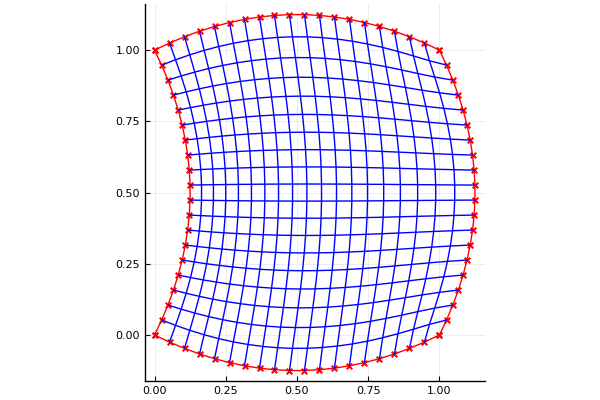

In [23]:
plot_mesh(crx,cry)

Iterace: 10	chyba:0.025293356720964624
Iterace: 20	chyba:0.009385314886533621
Iterace: 30	chyba:0.0037874461732360005
Iterace: 40	chyba:0.0015569793897105026
Iterace: 50	chyba:0.0006498131539460579
Iterace: 60	chyba:0.0002748559065607862
Iterace: 70	chyba:0.00011747797521457042


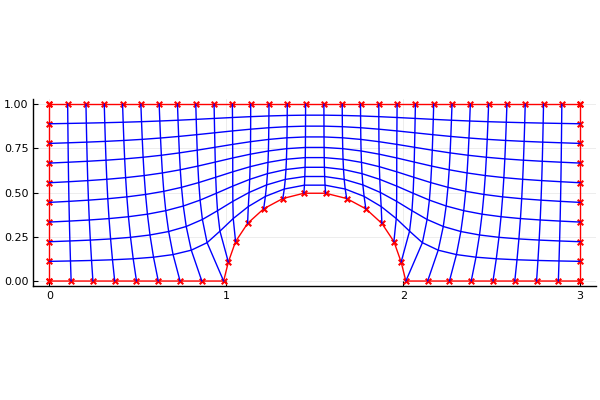

In [24]:
elliptic_mesh!(chx,chy)
plot_mesh(chx,chy)

Iterace: 10	chyba:0.07253323921072247
Iterace: 20	chyba:0.03250903461089574
Iterace: 30	chyba:0.014669191032495726
Iterace: 40	chyba:0.006584307074631149
Iterace: 50	chyba:0.002940124255083744
Iterace: 60	chyba:0.0013076851405206852
Iterace: 70	chyba:0.0005799512474287782
Iterace: 80	chyba:0.00025667235486164793
Iterace: 90	chyba:0.0001134262926919459


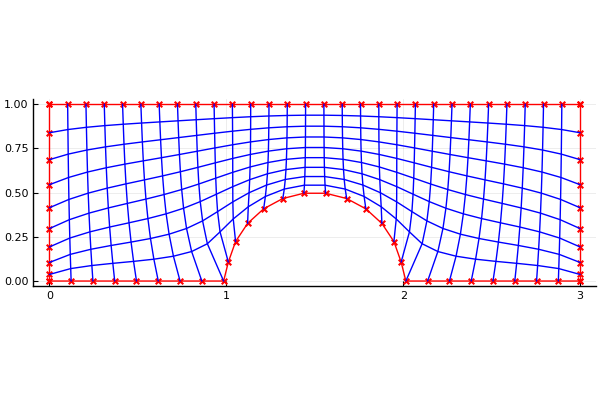

In [25]:
elliptic_mesh!(nsx,nsy)
plot_mesh(nsx,nsy)

### Vliv zdrojových členů
* $P>0$ posouvá síťové čáry doprava 
* $P<0$ posouvá síťové čáry doleva 
* $Q>0$ posouvá síťové čáry nahoru
* $Q<0$ posouvá síťové čáry dolu 

Iterace: 10	chyba:0.09718900212934224
Iterace: 20	chyba:0.04582481004682679
Iterace: 30	chyba:0.02099217843844984
Iterace: 40	chyba:0.009546409047234826
Iterace: 50	chyba:0.004343517607068747
Iterace: 60	chyba:0.0019821381010104626
Iterace: 70	chyba:0.0009079188170344935
Iterace: 80	chyba:0.0004174645309603293
Iterace: 90	chyba:0.0001926467882028449


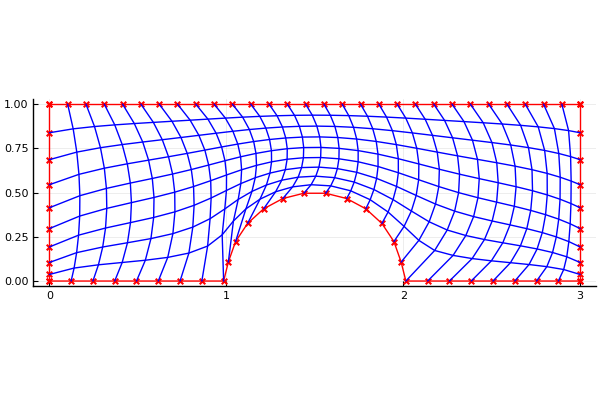

In [26]:
elliptic_mesh!(nsx,nsy, P=(i,j)->0.2);
plot_mesh(nsx,nsy)

Iterace: 10	chyba:0.09616011183108161
Iterace: 20	chyba:0.043835624859440925
Iterace: 30	chyba:0.020138895782349835
Iterace: 40	chyba:0.0093501655113085
Iterace: 50	chyba:0.004392685894105371
Iterace: 60	chyba:0.0020901442583537
Iterace: 70	chyba:0.0010077451685745655
Iterace: 80	chyba:0.0004918911054182891
Iterace: 90	chyba:0.00024249803635635988
Iterace: 100	chyba:0.00012034423465181733


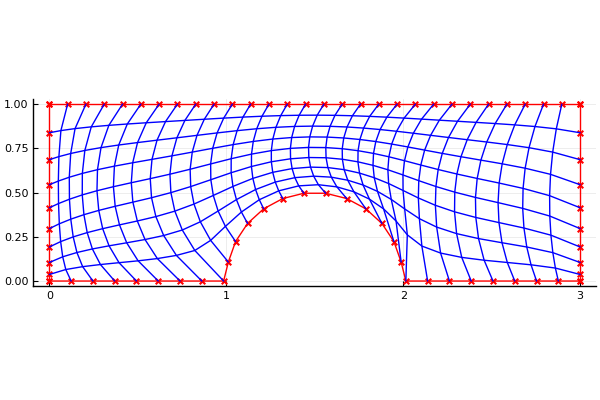

In [27]:
elliptic_mesh!(nsx,nsy, P=(i,j)-> -0.2);
plot_mesh(nsx,nsy)

Iterace: 10	chyba:0.05369077228878559
Iterace: 20	chyba:0.02149757453103209
Iterace: 30	chyba:0.008211333646805343
Iterace: 40	chyba:0.0030593694482832982
Iterace: 50	chyba:0.001127618364581941
Iterace: 60	chyba:0.0004131166855836626
Iterace: 70	chyba:0.00015077143503666846


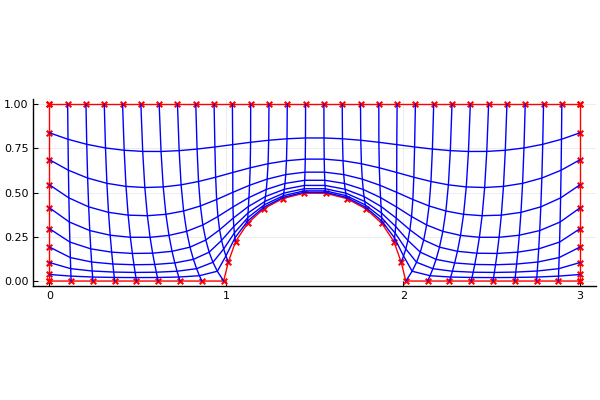

In [28]:
elliptic_mesh!(nsx,nsy, Q=(i,j)->-0.4);
plot_mesh(nsx,nsy)

### Automatická volba P a Q (kolmost na hranici + velikost první buňky)

* vytvoříme síť s body v první vrstvě v požadované vzdálenosti
* z kolmosti na hranici a z rovnice rovnice určíme P a Q na hranici
* provedeme transfinitní interpolaci P a Q do vnitřku oblasti
* vygenerujeme síť

In [29]:
# Vypocet poli P,Q z castecne vytvorene site (body na hranici + 1. vrstva)

function calculate_PQ(x, y)
    n,m = size(x)
    
    P = zeros(n,m)
    Q = zeros(n,m)

    r(i,j) = [x[i,j], y[i,j]]
    
    for i=2:n-1
        j = 1

        r_ξ  = ( r(i+1,j) - r(i-1,j) ) / 2.0
        r_ξξ = r(i+1,j) - 2*r(i,j) + r(i-1,j)

        Δy = norm( r(i,j+1) - r(i,j) )
        r_η = Δy * [ -r_ξ[2], r_ξ[1] ] / norm(r_ξ)
        r_ηη = [0.0, 0.0]
        
        g_11 = dot(r_ξ,r_ξ)
        g_12 = dot(r_ξ,r_η)
        g_22 = dot(r_η,r_η)
        
        P[i,j] = -dot(r_ξ,r_ξξ) / g_11 - dot(r_ξ,r_ηη) / g_22 
        Q[i,j] = -dot(r_η,r_ηη) / g_22 - dot(r_η,r_ξξ) / g_11 
               
        j = m
        r_ξ  = ( r(i+1,j) - r(i-1,j) ) / 2.0
        r_ξξ = r(i+1,j) - 2*r(i,j) + r(i-1,j)

        Δy   = norm( r(i,j) - r(i,j-1) )
        r_η  = Δy * [ -r_ξ[2], r_ξ[1] ] / norm(r_ξ)
        r_ηη = [0.0, 0.0] 
        
        g_11 = dot(r_ξ,r_ξ)
        g_12 = dot(r_ξ,r_η)
        g_22 = dot(r_η,r_η)
        
        P[i,j] = -dot(r_ξ,r_ξξ) / g_11 - dot(r_ξ,r_ηη) / g_22 
        Q[i,j] = -dot(r_η,r_ηη) / g_22 - dot(r_η,r_ξξ) / g_11 
    end    
    
    for j=2:m-1
        i = 1
        r_η  = ( r(i,j+1)-r(i,j-1) ) / 2.0
        r_ηη = r(i,j+1) - 2*r(i,j) + r(i,j-1)
        Δx   = norm(r(i+1,j) - r(i,j))
        r_ξ  =  Δx * [ r_η[2], -r_η[1]] / norm(r_η)
        r_ξξ = [0.0, 0.0]
        
        g_11 = dot(r_ξ,r_ξ)
        g_12 = dot(r_ξ,r_η)
        g_22 = dot(r_η,r_η)
        
        P[i,j] = -dot(r_ξ,r_ξξ) / g_11 - dot(r_ξ,r_ηη) / g_22 
        Q[i,j] = -dot(r_η,r_ηη) / g_22 - dot(r_η,r_ξξ) / g_11 

        i = n
        r_η  = ( r(i,j+1)-r(i,j-1) ) / 2.0
        r_ηη = r(i,j+1) - 2*r(i,j) + r(i,j-1)
        Δx   = norm(r(i,j) - r(i-1,j))
        r_ξ  =  Δx * [ r_η[2], -r_η[1]] / norm(r_η)
        Δ2   = norm(r(i,j)-r(i-2,j))
        r_ξξ = [0.0, 0.0]

        g_11 = dot(r_ξ,r_ξ)
        g_12 = dot(r_ξ,r_η)
        g_22 = dot(r_η,r_η)
        
        P[i,j] = -dot(r_ξ,r_ξξ) / g_11 - dot(r_ξ,r_ηη) / g_22 
        Q[i,j] = -dot(r_η,r_ηη) / g_22 - dot(r_η,r_ξξ) / g_11 
    end    
        
    linear_tfi!(P,Q)
    
    return P,Q
end

calculate_PQ (generic function with 1 method)

In [30]:
double_tfi!(nsx,nsy);
P, Q = calculate_PQ(nsx,nsy);

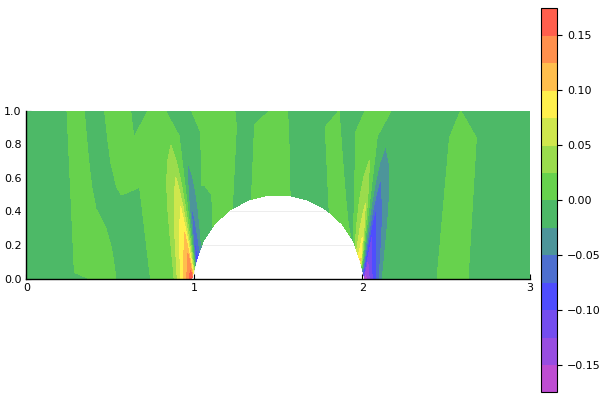

In [31]:
plot(nsx,nsy,P,st=:contour,fill=true,color=:lightrainbow,aspect_ratio=:equal)

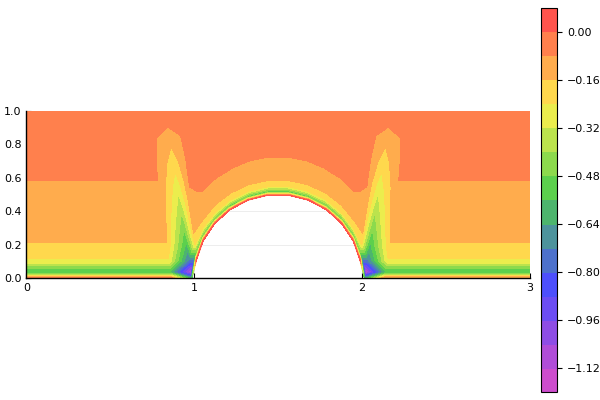

In [32]:
plot(nsx,nsy,Q,st=:contour,fill=true,color=:lightrainbow,aspect_ratio=:equal)

In [33]:
elliptic_mesh!(nsx, nsy, P=(i,j)->P[i,j], Q=(i,j)->Q[i,j])

Iterace: 10	chyba:0.025979911492018296
Iterace: 20	chyba:0.010065908729148504
Iterace: 30	chyba:0.0040843439031585105
Iterace: 40	chyba:0.0016525984114782197
Iterace: 50	chyba:0.0006624127202057112
Iterace: 60	chyba:0.0002632381598324683
Iterace: 70	chyba:0.00010390533627741301


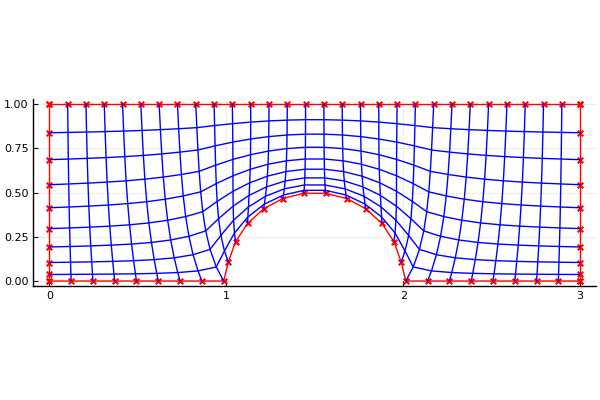

In [34]:
plot_mesh(nsx,nsy)

In [35]:
fx,fy = channel_ns(90,30)
linear_tfi!(fx,fy)
FP,FQ = calculate_PQ(fx,fy)
elliptic_mesh!(fx, fy, maxiter=1000, P=(i,j)->FP[i,j], Q=(i,j)->FQ[i,j])

Iterace: 10	chyba:0.02983593223015002
Iterace: 20	chyba:0.022609299864827577
Iterace: 30	chyba:0.01868837822950738
Iterace: 40	chyba:0.01603133543174228
Iterace: 50	chyba:0.01403672295132881
Iterace: 60	chyba:0.012446249548378651
Iterace: 70	chyba:0.011127168954290396
Iterace: 80	chyba:0.010003585856033472
Iterace: 90	chyba:0.009028708399342734
Iterace: 100	chyba:0.008171848551751541
Iterace: 110	chyba:0.00741175449175938
Iterace: 120	chyba:0.00673298128878446
Iterace: 130	chyba:0.006123824675595414
Iterace: 140	chyba:0.005575097836878587
Iterace: 150	chyba:0.005079379776977755
Iterace: 160	chyba:0.004630536114129113
Iterace: 170	chyba:0.004223402198083443
Iterace: 180	chyba:0.0038535660003210554
Iterace: 190	chyba:0.0035172142967330347
Iterace: 200	chyba:0.0032110202954076014
Iterace: 210	chyba:0.0029320592625662334
Iterace: 220	chyba:0.0026777436336617375
Iterace: 230	chyba:0.002445772064204073
Iterace: 240	chyba:0.0022340887046642215
Iterace: 250	chyba:0.002040850141564243
Iterace: 

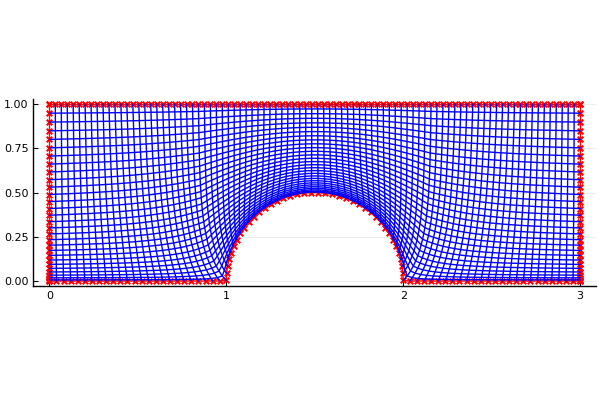

In [36]:
plot_mesh(fx,fy)

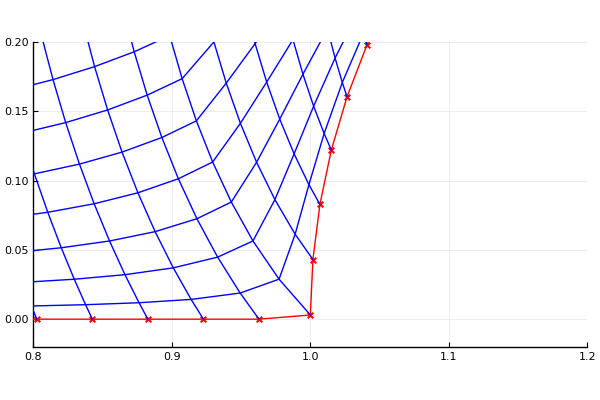

In [37]:
plt=plot_mesh(fx,fy)
plot!(plt, xlim=(0.8,1.2), ylim=(-0.02,0.2))

---

## Hyperbolický generátor

Označme $\vec{r}=[x,y]$.

Ortogonalita:
$$
    \vec{r}_\xi \cdot \vec{r}_\eta = 0.
$$

Velikost (plocha) buňky:
$$
    \vec{r}_\xi \times \vec{r}_\eta = V(\xi,\eta).
$$

Linearizace v okolí bodu $\bar{\vec{r}}$: ($\vec{r} = \bar{\vec{r}} + \vec{r}'$)
\begin{align*}
    \vec{r}_\xi \cdot \vec{r}_\eta &\approx \bar{\vec{r}}_\xi \cdot \bar{\vec{r}}_\eta + \vec{r}'_\xi \cdot \bar{\vec{r}}_\eta + \bar{\vec{r}}_\xi \cdot \vec{r}'_\eta, \\
    \vec{r}_\xi \times \vec{r}_\eta &\approx \bar{\vec{r}}_\xi \times \bar{\vec{r}}_\eta + \vec{r}'_\xi \times \bar{\vec{r}}_\eta + \bar{\vec{r}}_\xi \times \vec{r}'_\eta
\end{align*}

Dosazením $\vec{r}' = \vec{r} - \bar{\vec{r}}$ a zanedbáním členů druhého řádu:
\begin{align*}
    \vec{r}_\xi \cdot \vec{r}_\eta &\approx \vec{r}_\xi \cdot \bar{\vec{r}}_\eta + \bar{\vec{r}}_\xi \cdot \vec{r}_\eta - \bar{\vec{r}}_\xi \cdot \bar{\vec{r}}_\eta, \\
    \vec{r}_\xi \times \vec{r}_\eta &\approx \vec{r}_\xi \times \bar{\vec{r}}_\eta + \bar{\vec{r}}_\xi \times \vec{r}_\eta - \bar{\vec{r}}_\xi \times \bar{\vec{r}}_\eta, \\
\end{align*}

a tedy

\begin{align*}
    \vec{r}_\xi \cdot \bar{\vec{r}}_\eta + \bar{\vec{r}}_\xi \cdot \vec{r}_\eta &= 0, \\
    \vec{r}_\xi \times \bar{\vec{r}}_\eta + \bar{\vec{r}}_\xi \times \vec{r}_\eta &= V(\xi,\eta) + \bar{V}.
\end{align*}

V maticovém tvaru
$$
    \mathbf B \vec{r}_\eta + \mathbf A \vec{r}_\xi = \vec f,
$$
kde
$$
    \mathbf A = \begin{pmatrix} 
    \bar{x}_\eta & \bar{y}_\eta\\
    \bar{y}_\eta & - \bar{x}_\eta
    \end{pmatrix},
    \,
    \mathbf B = \begin{pmatrix} 
    \bar{x}_\xi & \bar{y}_\xi \\
    -\bar{y}_\xi & \bar{x}_\xi
    \end{pmatrix},
    \,
    \vec f = \begin{pmatrix} 
    0 \\ V+\bar{V}
    \end{pmatrix}.
$$

Systém lze upravit na
$$
    \vec{r}_\eta + \mathbf C \vec{r}_\xi = \vec{g},
$$
kde
\begin{align*}
  \mathbf C &= \mathbf B^{-1} \mathbf A = 
  \frac{1}{\bar{x}_\xi^2+\bar{y}_\xi^2}
  \left[
    \begin{array}{cc}
      \bar{x}_\xi \bar{x}_\eta  - \bar{y}_\xi \bar{y}_\eta
      &
      \bar{x}_\xi \bar{y}_\eta  + \bar{y}_\xi \bar{x}_\eta
      \\
      \bar{y}_\xi \bar{x}_\eta  + \bar{x}_\xi \bar{y}_\eta
      &
      \bar{y}_\xi \bar{y}_\eta  - \bar{x}_\xi \bar{x}_\eta
    \end{array}
  \right],
  \\
  \vec{g}  &= \mathbf B^{-1} \vec{f} =
  \frac{\bar{V}+V}{\bar{x}_\xi^2+\bar{y}_\xi^2}
  \left[
    \begin{array}{c}
      -\bar{y}_\xi \\
       \bar{x}_\xi 
    \end{array}
  \right].
\end{align*}

Vlastní čísla matice $\mathbf C$:
\begin{equation}
  \lambda_{\mathbf C} = \frac{\pm \sqrt{2}}
  {\bar{x}_\xi^2+\bar{y}_\xi^2}
  \sqrt{ \bar{x}_\xi^2 \bar{x}_\eta^2  + 
    \bar{y}_\xi^2 \bar{y}_\eta^2}.
\end{equation}


### Explicitní schéma

$$
    \vec{r}_{i,j+1} = \vec{r}_{i,j} - \frac{1}{2} \mathbf C_{i,j} (\vec{r}_{i+1,j} - \vec{r}_{i-1,j}) + \vec{g}_{i,j}
    + \epsilon (\vec{r}_{i+1,j} - 2 \vec{r}_{i,j} + \vec{r}_{i-1,j}).
$$

Podmínka stability $\Delta \eta \le CFL \, \Delta \xi / \rho_{\mathbf C}$, kde $CFL \approx 1$ a $\Delta \eta = \Delta \xi = 1$

In [38]:
# parametrizace spodni strany oblasti, 0 <= t <= 1
function lower_wall(t)
    cx = 1.5
    cy = - (0.25 - 0.01) / 0.2
    r2 = 0.25 + cy^2
    
    x = 3.0 * t
    if 1<x && x<2
        y = √(r2-(x-cx)^2) + cy
    else
        y = 0.0
    end
    return [x,y]
end

lower_wall (generic function with 1 method)

In [39]:
function ddξ(r)
    r_ξ = similar(r)
    r_ξ[:,1] = r[:,2] .- r[:,1]
    r_ξ[:,2:end-1] = ( r[:,3:end] .- r[:,1:end-2] ) ./ 2.0
    r_ξ[:,end] = r[:,end] .- r[:,end-1]
    return r_ξ
end;


function d2dξ2(r)
    r_ξξ = similar(r)
    r_ξξ[:,1] .= 0.0
    r_ξξ[:,2:end-1] .= ( r[:,3:end] .- 2*r[:,2:end-1] .+ r[:,1:end-2] ) 
    r_ξξ[:,end] .= 0.0
    return r_ξξ
end;


function hyp_explicit_central(n, m, Δy=1.e-3, ratio=1.2)
    r = zeros(2,n,m)

    # Sestaveni spodni steny
    for i = 1:n
        r[:,i,1] = lower_wall( (i-1)/(n-1) )
    end

    C = zeros(2,2)
    g = zeros(2)
        
    for j=1:m-1
        
        r_ξ = ddξ(r[:,:,j])
        r_ξξ = d2dξ2(r[:,:,j])
        Δx = [ norm(r_ξ[:,i]) for i = 1:n ]
        r_η = similar(r_ξ)
        for i = 1:n
            r_η[:,i] .= [ -r_ξ[2,i]; r_ξ[1,i] ] * Δy / Δx[i] 
        end
        
        Vb = Δx * Δy
        V = Vb * ratio
    
        for i = 1:n
            C[1,1] = (r_ξ[1,i] * r_η[1,i] - r_ξ[2,i] * r_η[2,i]) / Δx[i]^2 
            C[1,2] = (r_ξ[1,i] * r_η[2,i] + r_ξ[2,i] * r_η[1,i]) / Δx[i]^2 
            C[2,1] = C[1,2]
            C[2,2] = - C[1,1]
            
            g[1] = - (V[i] + Vb[i]) / Δx[i]^2 * r_ξ[2,i]
            g[2] =   (V[i] + Vb[i]) / Δx[i]^2 * r_ξ[1,i]
            
            σ =  √2 * √(r_ξ[1,i]^2 * r_η[1,i]^2 + r_ξ[2,i]^2 * r_η[2,i]^2) / Δx[i]^2

            r[:,i,j+1] .= r[:,i,j] .- C * r_ξ[:,i] .+ g .+ σ/2 .* r_ξξ[:,i]
        end
        
        Δy = ratio * Δy
    end
    
    return r
end;

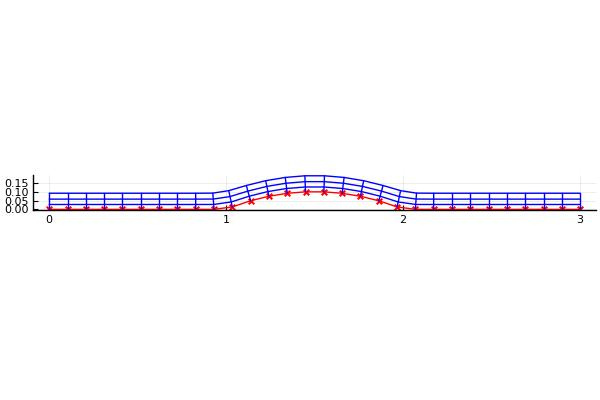

In [40]:
r = hyp_explicit_central(30,4,0.025,1.1);
plot_mesh(r)

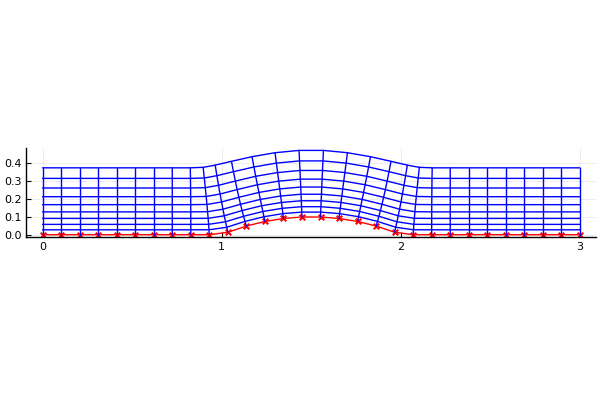

In [41]:
r = hyp_explicit_central(30,10,0.025,1.1);
plot_mesh(r)

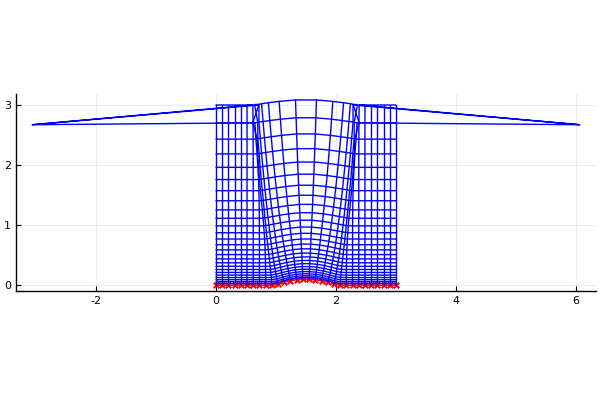

In [42]:
r = hyp_explicit_central(30,27,0.025,1.1);
plot_mesh(r)

In [43]:
function hyp_explicit_upwind(n, m, Δy=1.e-3, ratio=1.2)
    r = zeros(2,n,m)

    # Sestaveni spodni steny
    for i = 1:n
        r[:,i,1] = lower_wall( (i-1)/(n-1) )
    end

    C = zeros(2,2)
    g = zeros(2)
    Vb = zeros(n)
    V = similar(Vb)
    
    for j=1:m-1
        
        r_ξ = ddξ(r[:,:,j])
        Δx = [ norm(r_ξ[:,i]) for i = 1:n ]
        r_η = similar(r_ξ)
        for i = 1:n
            r_η[:,i] .= [ -r_ξ[2,i]; r_ξ[1,i] ] * Δy / Δx[i]
        end
        
        Vb = Δx * Δy
        V = ratio * (Vb + 0.1 * d2dξ2(Vb))
        
        for i = 1:n
            C[1,1] = (r_ξ[1,i] * r_η[1,i] - r_ξ[2,i] * r_η[2,i]) / Δx[i]^2 
            C[1,2] = (r_ξ[1,i] * r_η[2,i] + r_ξ[2,i] * r_η[1,i]) / Δx[i]^2 
            C[2,1] = C[1,2]
            C[2,2] = - C[1,1]

            eig = eigen(C)
            Λ,R = eig.values, eig.vectors
            C⁺ = R * Diagonal(max.(Λ,0.0)) * inv(R)
            C⁻ = C - C⁺
            
            g[1] = - (V[i] + Vb[i]) / Δx[i]^2 * r_ξ[2,i]
            g[2] =   (V[i] + Vb[i]) / Δx[i]^2 * r_ξ[1,i]
            
            i⁺ = min(i,n-1)
            Δ⁺ = r[:,i⁺+1,j] .- r[:,i⁺,j]

            i⁻ = max(i,2)
            Δ⁻ = r[:,i⁻,j] .- r[:,i⁻-1,j]

            r[:,i,j+1] .= r[:,i,j] .- C⁺ * Δ⁻ .- C⁻ * Δ⁺ .+ g
        end
        
        Δy = ratio * Δy
    end
    
    return r
end;

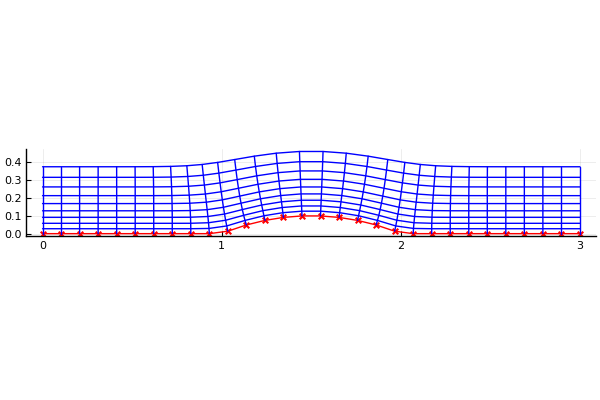

In [44]:
r = hyp_explicit_upwind(30,10,0.025,1.1);
plot_mesh(r)

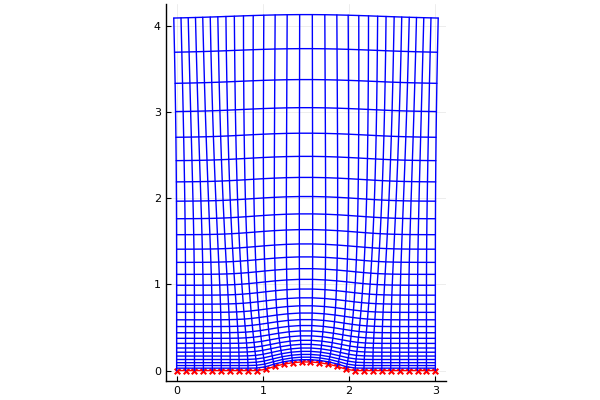

In [45]:
r = hyp_explicit_upwind(30,30,0.025,1.1);
plot_mesh(r)

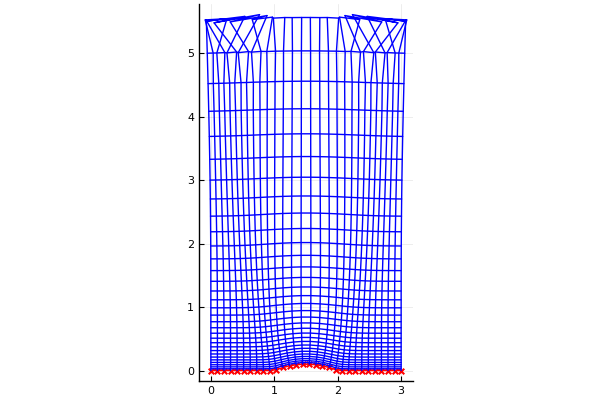

In [46]:
r = hyp_explicit_upwind(30,33,0.025,1.1);
plot_mesh(r)

In [47]:
using SparseArrays

In [48]:
function hyp_implicit_upwind(n, m, Δy=1.e-3, ratio=1.2, init=lower_wall)
    r = zeros(2,n,m)

    # Sestaveni spodni steny
    for i = 1:n
        r[:,i,1] .= init( (i-1)/(n-1) )
    end

    C = zeros(2,2)
    g = zeros(2)


    for j=1:m-1
        
        r_ξ = ddξ(r[:,:,j])
        Δx = [ norm(r_ξ[:,i]) for i = 1:n ]
        r_η = similar(r_ξ)
        if j==1
            for i = 1:n
                r_η[:,i] .= [ -r_ξ[2,i]; r_ξ[1,i] ] * Δy / Δx[i] 
            end
        else
            r_η .= r[:,:,j] .- r[:,:,j-1]
        end
        #r_η[:,1] = [0.0, Δy]
        #r_η[:,end] = [0.0, Δy]

        r_η[:,1] .= [0.0, sign(r_η[2,2])*Δy]
        r_η[:,end] .= [0.0, sign(r_η[2,end-1])*Δy]

        V = Δx * Δy
        Vb = r_ξ[1,:].*r_η[2,:] .- r_ξ[2,:].*r_η[1,:]
        
        A = sparse(1.0*I,2*n,2*n)
        b = zeros(2*n)
        
        
        for i = 1:n
            C[1,1] = (r_ξ[1,i] * r_η[1,i] - r_ξ[2,i] * r_η[2,i]) / Δx[i]^2 
            C[1,2] = (r_ξ[1,i] * r_η[2,i] + r_ξ[2,i] * r_η[1,i]) / Δx[i]^2 
            C[2,1] = C[1,2]
            C[2,2] = - C[1,1]
            
            eig = eigen(C)
            Λ,R = eig.values, eig.vectors
            C⁺ = R * Diagonal(max.(Λ,0.0)) * inv(R)
            C⁻ = C - C⁺
            
            g[1] = - (V[i] + Vb[i]) / Δx[i]^2 * r_ξ[2,i]
            g[2] =   (V[i] + Vb[i]) / Δx[i]^2 * r_ξ[1,i]

            k = 2*(i-1) + 1
            if 1<i && i<n
                kl = k - 2
                kr = k + 2
                
                A[k:k+1,k:k+1] .= Matrix(1.0*I,2,2) .+ C⁺ .- C⁻
                A[k:k+1,kl:kl+1] .= - C⁺
                A[k:k+1,kr:kr+1] .=   C⁻                
            end
            
            b[k:k+1] = r[:,i,j] + g
        end
            
        b[1:2] .= r[:,1,j] .+ r_η[:,1]
        b[end-1:end] = r[:,end,j] + r_η[:,end]
            
        dr = A \ b
        r[:,:,j+1] .= reshape(dr, (2,n))
        
        Δy = ratio * Δy
    end
    
    return r
end;

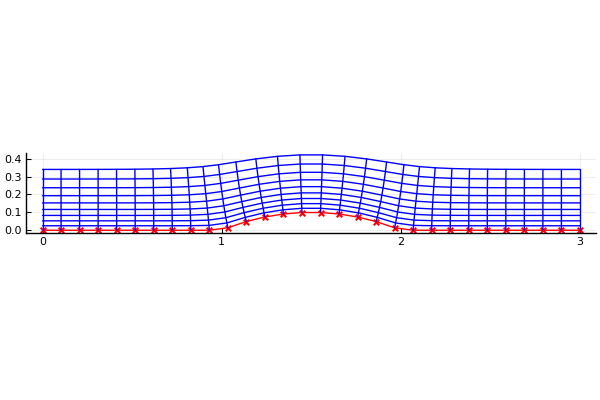

In [49]:
r = hyp_implicit_upwind(30,10,0.025,1.1);
plot_mesh(r)

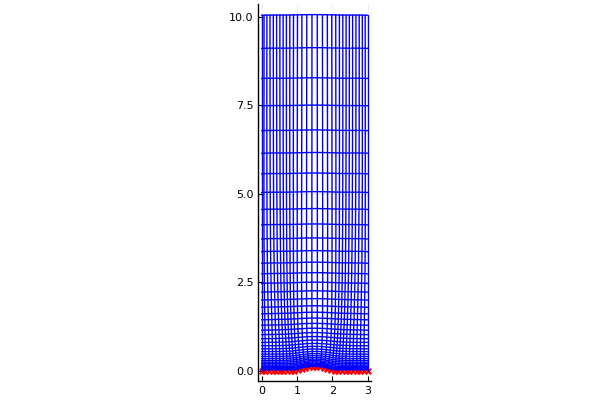

In [50]:
r = hyp_implicit_upwind(30,40,0.025,1.1);
plot_mesh(r)

### Hyperbolická C-síť kolem izolovaného profilu

In [51]:
function naca0012(t)
    s = t*4
    if s<1
        return [3-2*s, 0.0]
    elseif s>3
        return [2*s-5, 0.0]
    else
        x = abs(s-2)^2
        y = 0.594689181*(0.298222773*sqrt(x) - 0.127125232*x - 0.357907906*x^2 + 0.291984971*x^3 - 0.105174606*x^4)
        if s<2
            return [x,-y]
        else
            return [x, y]
        end
    end
end         

naca0012 (generic function with 1 method)

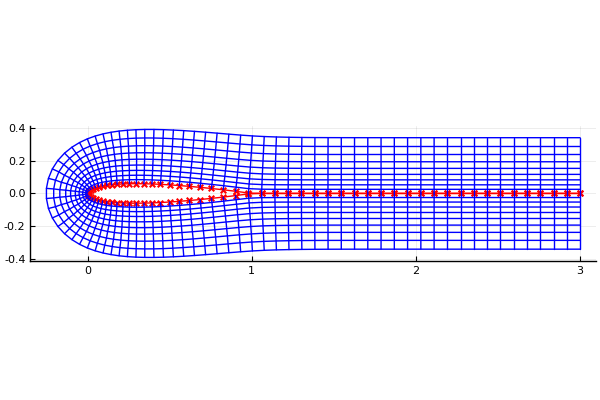

In [52]:
q = hyp_implicit_upwind(100,10,0.025,1.1,naca0012);
plot_mesh(q)

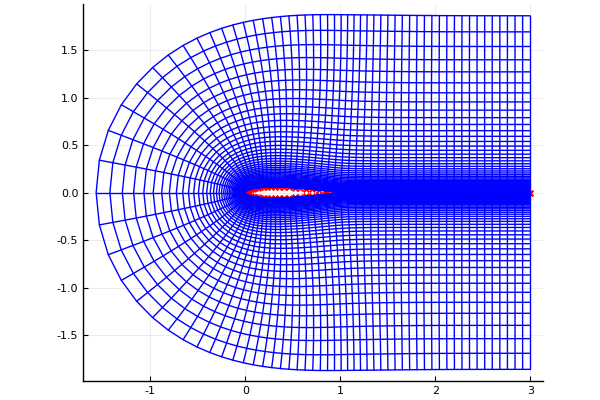

In [53]:
q = hyp_implicit_upwind(101,80,1e-4,1.1,naca0012);
plot_mesh(q)

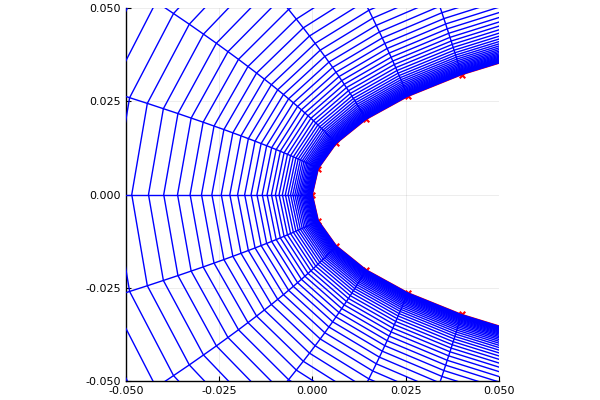

In [54]:
plt=plot_mesh(q)
plot!(plt, xlim=(-0.05,0.05), ylim=(-0.05,0.05))

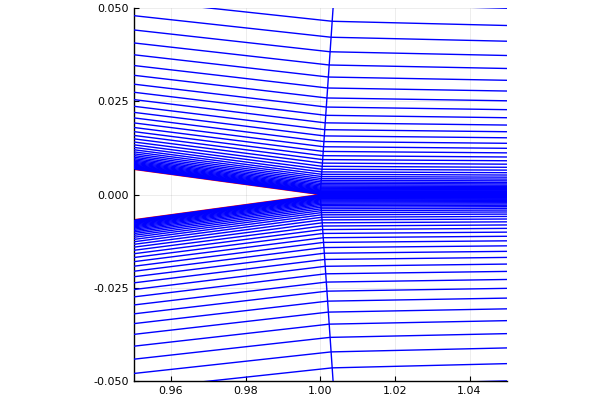

In [55]:
plt=plot_mesh(q);
plot!(plt, xlim=(0.95,1.05), ylim=(-0.05,0.05))